In [1]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.root"

In [2]:
import time
import os
import numpy as np
import gc
from mu2etools import *
from mu2etools import wideband
import hist
from hist import Hist

hep.style.use('ATLAS')

In [3]:
runs = [2070]
processor = wideband.DataProcessor(treename='run', runlist=runs, userunlist=True, remove=False,fixtimes=True)
filelist = processor.getFilelist(DATASET, root_schema=True)
filelist = ["{}{}".format(i, ":run") for i in filelist]

In [9]:
varlist = ['PEs','time']

h = Hist(hist.axis.Regular(bins=200, start=-100, stop=100, name="time difference"))

for idx, filename in enumerate(filelist):
    print(filename)
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="100MB", 
                               filter_name=varlist, 
                               report=False, library='ak'):
            ar['PEs'] = ak.where(ar['PEs'] >= 5, ar['PEs'], 0)
            for chan in range(64):
                ar_chan = ar[(ar['PEs'][:,0,chan] > 0)]
                ar_chan['timediff'] = ar_chan['time'][:,0,chan] - ar_chan['time'][:,4,chan]
                h.fill(ar_chan['timediff'])

root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/7c/4f/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_001.root:run
root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/1e/da/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_002.root:run
root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/bc/ec/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_003.root:run
root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/6d/35/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_004.root:run


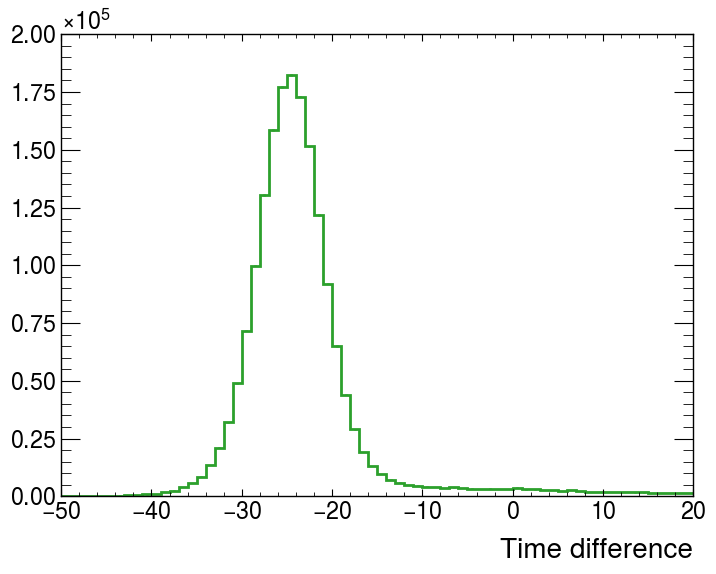

In [10]:
fig, ax = plt.subplots()
h.plot1d(color='#2ca02c', linewidth=2.0)
ax.set_xlabel('Time difference')
#ax.set_yscale('log')
ax.set_xlim(-50, 20)
plt.show()

In [16]:
varlist = ['PEs','time','fitStatus']

hc1 = Hist(hist.axis.Regular(bins=200, start=0, stop=1, name="speed of light"))
hc2 = Hist(hist.axis.Regular(bins=200, start=0, stop=1, name="speed of light"))

for idx, filename in enumerate(filelist):
    print(filename)
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="10MB", 
                               filter_name=varlist, 
                               report=False, library='ak'):
            ar['PEs'] = ak.where(ar['PEs'] >= 20, ar['PEs'], 0) # much more strict cut
            for chan in range(64):
                for FEB in range(2):
                    ar_chan = ar[(ar['PEs'][:,FEB,chan] > 0) & (ar['PEs'][:,FEB+4,chan] > 0) & (ar['fitStatus'][:,FEB,chan] == 1) & (ar['fitStatus'][:,FEB+4,chan] == 1)]
                    ar_chan['c'] = 4/((ar_chan['time'][:,FEB+4,chan] - ar_chan['time'][:,FEB,chan])*0.299792458)
                    hc1.fill(ar_chan['c'])

                    ar_chan = ar[(ar['PEs'][:,FEB+2,chan] > 0) & (ar['PEs'][:,FEB+6,chan] > 0) & (ar['fitStatus'][:,FEB+2,chan] == 1) & (ar['fitStatus'][:,FEB+6,chan] == 1)]
                    ar_chan['c'] = 4/((ar_chan['time'][:,FEB+6,chan] - ar_chan['time'][:,FEB+2,chan])*0.299792458)
                    hc2.fill(ar_chan['c'])

root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/7c/4f/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_001.root:run
root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/1e/da/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_002.root:run
root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/bc/ec/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_003.root:run


/home/thoroho/.conda/envs/Mu2eCRV/lib/python3.10/site-packages/awkward/_backends.py:57: RuntimeWarning: divide by zero encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/6d/35/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_004.root:run


In [18]:
bins = np.linspace(0.005, 0.995, 200)

mean1 = 0
std1 = 0
for i, val in enumerate(hc1.values()):
    mean1 += bins[i]*val
mean1 = mean1/hc1.sum()
for i, val in enumerate(hc1.values()):
    std1 += val*(bins[i] - mean1)**2
std1 = np.sqrt(std1/hc1.sum())

mean2 = 0
std2 = 0
for i, val in enumerate(hc2.values()):
    mean2 += bins[i]*val
mean2 = mean2/hc2.sum()
for i, val in enumerate(hc2.values()):
    std2 += val*(bins[i] - mean2)**2
std2 = np.sqrt(std2/hc2.sum())

print("Module 171")
print("----------------------------")
print("Mean:", mean1)
print("Standard deviation:", std1)

print("Module 169")
print("----------------------------")
print("Mean:", mean2)
print("Standard deviation:", std2)

Module 171
----------------------------
Mean: 0.5726916130839912
Standard deviation: 0.09456218688907514
Module 169
----------------------------
Mean: 0.5194104168983708
Standard deviation: 0.07712611536595332


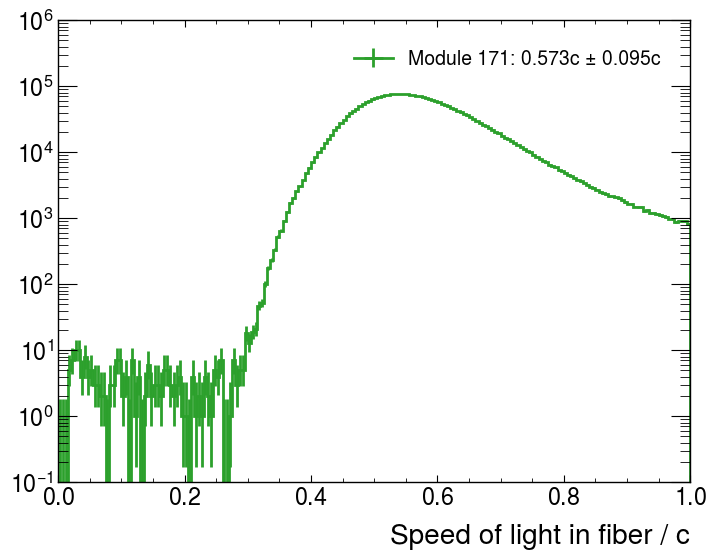

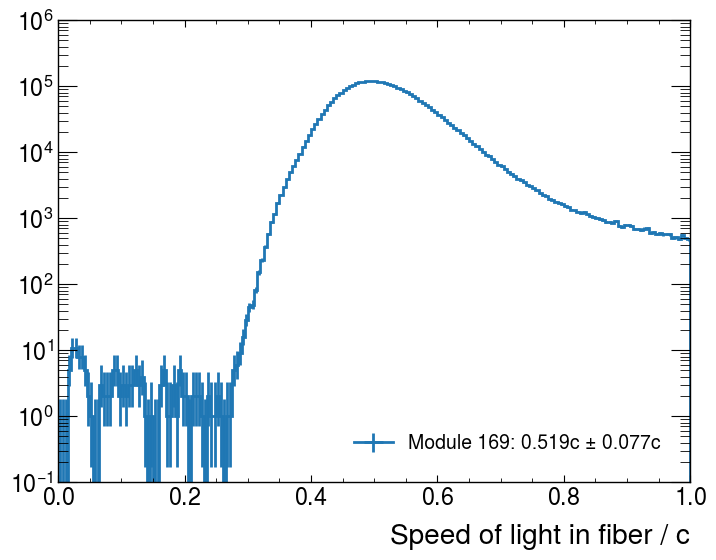

In [33]:
fig, ax = plt.subplots()
hc1.plot1d(color='#2ca02c', linewidth=2.0, label='Module 171: {0}c ± {1}c'.format(round(mean1,3), round(std1,3)))
ax.set_xlabel('Speed of light in fiber / c')
ax.set_xlim(0, 1)
ax.set_yscale('log')
ax.legend()
plt.show()

fig, ax = plt.subplots()
hc2.plot1d(color='#1f77b4', linewidth=2.0, label='Module 169: {0}c ± {1}c'.format(round(mean2,3), round(std2,3)))
ax.set_xlabel('Speed of light in fiber / c')
ax.set_xlim(0, 1)
ax.set_yscale('log')
ax.legend()
plt.show()

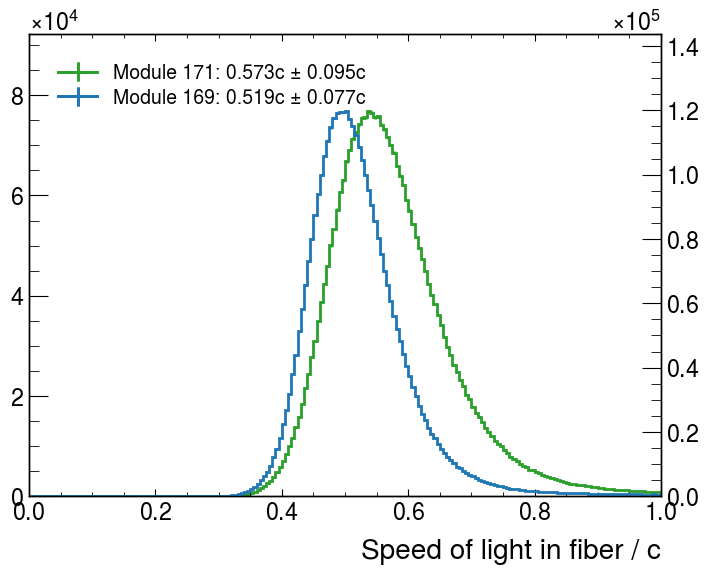

In [32]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
module171, = hc1.plot1d(ax=ax1, color='#2ca02c', linewidth=2.0, label='Module 171: {0}c ± {1}c'.format(round(mean1,3), round(std1,3)))
module169, = hc2.plot1d(ax=ax2, color='#1f77b4', linewidth=2.0, label='Module 169: {0}c ± {1}c'.format(round(mean2,3), round(std2,3)))
ax1.set_xlabel('Speed of light in fiber / c')
ax1.set_xlim(0, 1)
ax1.set_ylim(0,1.2*max(hc1.values()))
ax2.set_ylim(0,1.2*max(hc2.values()))

plts = [module171, module169]
labs = ['Module 171: {0}c ± {1}c'.format(round(mean1,3), round(std1,3)), 'Module 169: {0}c ± {1}c'.format(round(mean2,3), round(std2,3))]
ax1.legend(plts, labs, loc='upper left')

plt.show()